<div align='right'><h3> Yes, we **used similarity** to <font color='red'>find <i>related<i> words</font> but it was designed to <font color='blue'>predict context words</font> ! <h3>  </div>
  

# Data

## 1. Get a corpus

Original model was trained on a 100 billion words part of Google News Corpus. 
I don't think I can find it, and we are for sure not going to be able to use it.

We'll stick with Wikitext 2 version 1

Links: [Wikitext 2 Description](https://paperswithcode.com/dataset/wikitext-2) [Wikitext 2 Datasets Page](https://huggingface.co/datasets/wikitext/viewer/wikitext-2-v1/train)

In [9]:
from collections import Counter 
from tqdm.auto import tqdm, trange
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F


In [10]:
# Load the dataset
wikitext = load_dataset("wikitext", "wikitext-2-v1")
wikitext, wikitext['train'][10]['text']

(DatasetDict({
     test: Dataset({
         features: ['text'],
         num_rows: 4358
     })
     train: Dataset({
         features: ['text'],
         num_rows: 36718
     })
     validation: Dataset({
         features: ['text'],
         num_rows: 3760
     })
 }),
 ' The game \'s battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action <unk> . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked 

# Goals

PS: we do not replicate the paper Word2Vec but do something in the same spirit for now

**predict the next word, given past N words**

![Screenshot 2025-05-05 at 22.05.25.png](<attachment:Screenshot 2025-05-05 at 22.05.25.png>)


This is what we try to model: $ P(w_i | w_{i-1}, w_{i-2}, w_{i-3} \dots, w_{i-n+1})$ 

e.g. $P({\text{refuse} | \text{can't},\text{he}, \text{offer}, \text{an}, \text{him} })$
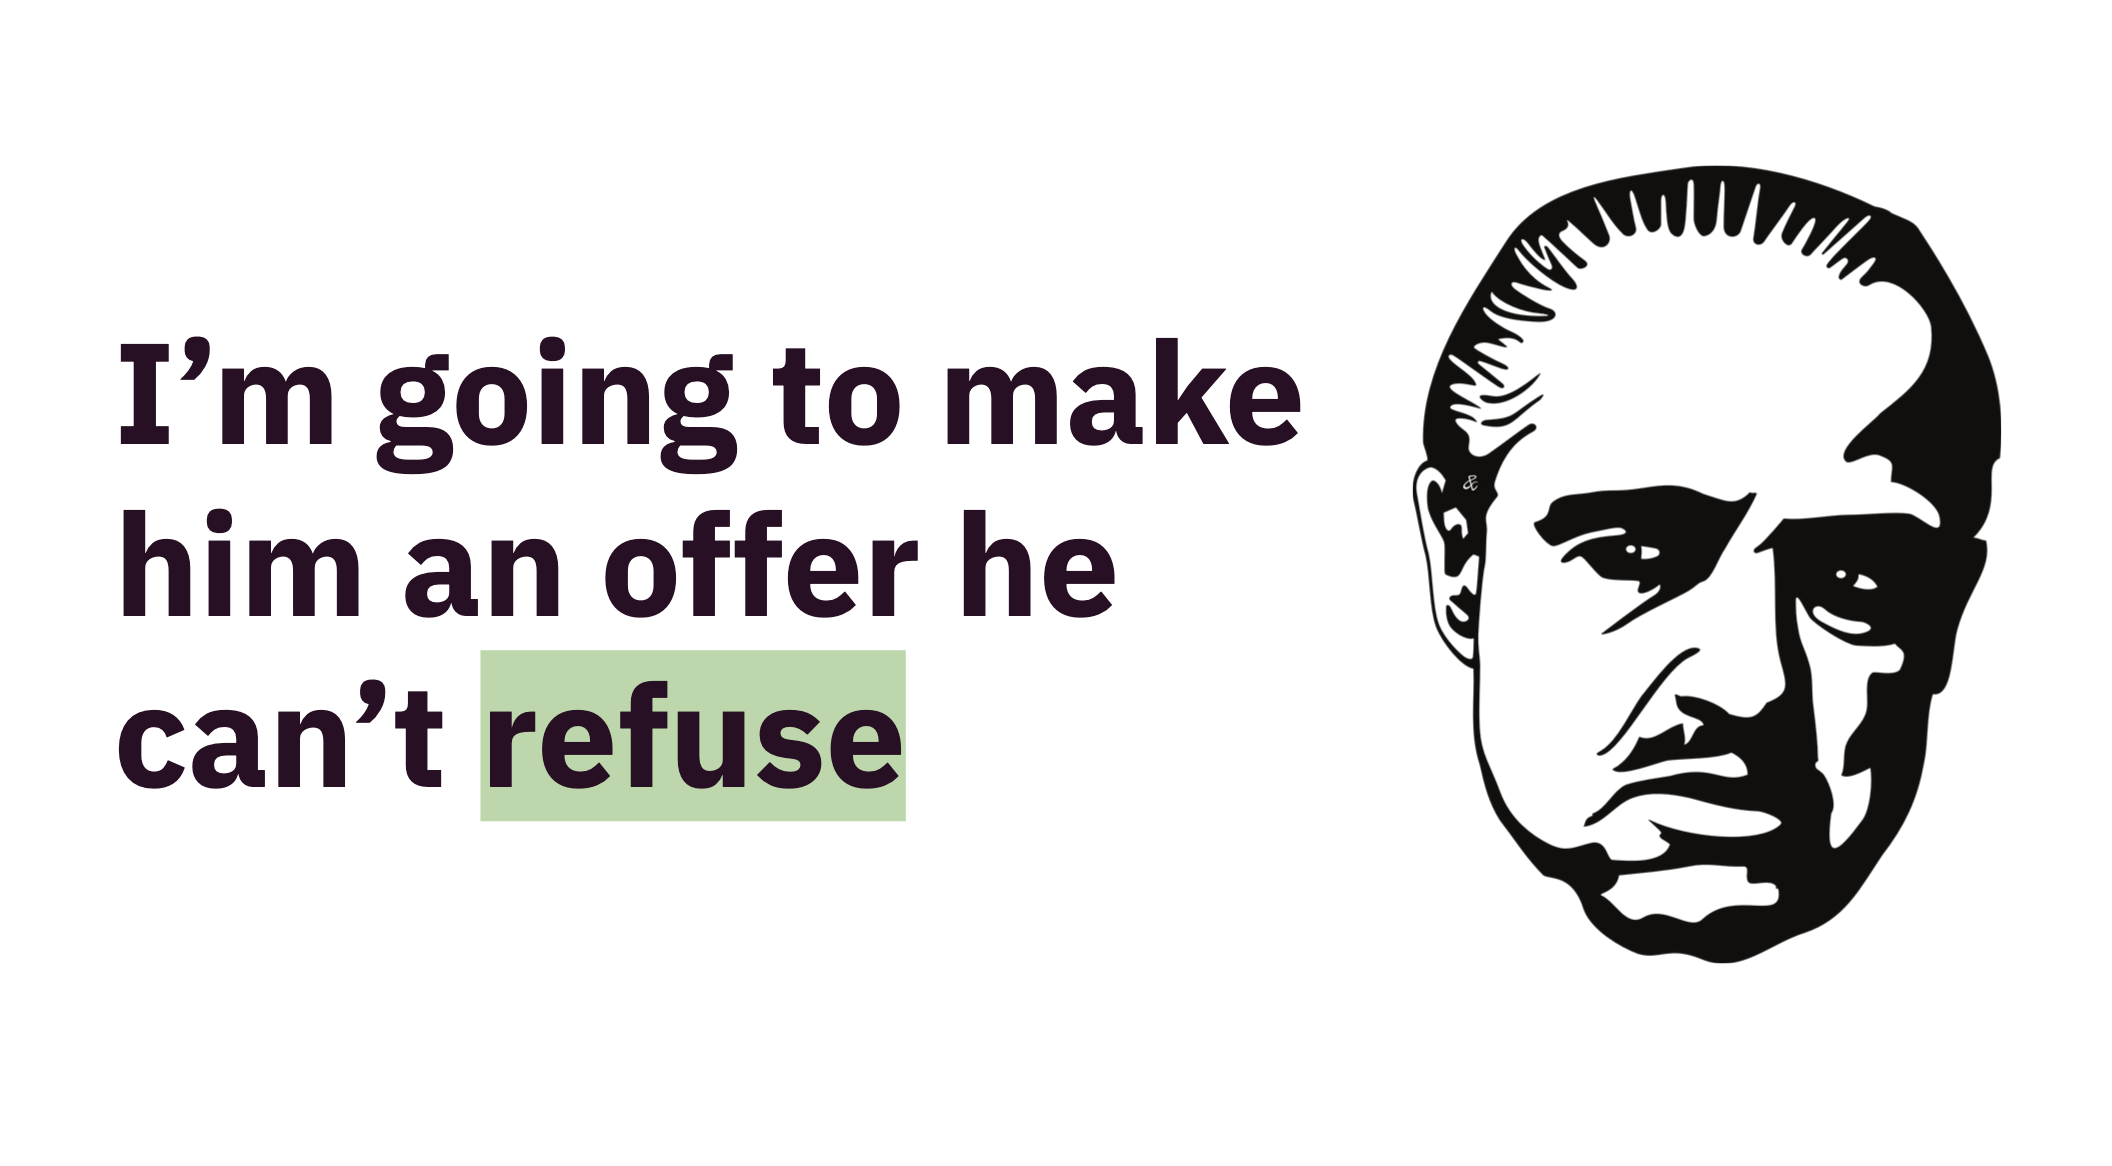

# How?

## Get a Vocab

You know the drill by now. Get a counter. Set n_words. Select top-n.

In [4]:
# Make a vocab
word_counter = Counter()
for line in tqdm(wikitext['train'], miniters=1000):
    word_counter.update(line['text'].split())
    
len(word_counter), word_counter.most_common(10)

100%|██████████| 36718/36718 [00:00<00:00, 81207.16it/s]


(33277,
 [('the', 113161),
  (',', 99913),
  ('.', 73388),
  ('of', 56889),
  ('<unk>', 54625),
  ('and', 50603),
  ('in', 39453),
  ('to', 39190),
  ('a', 34237),
  ('=', 29570)])

In [7]:
unk_token = '<unk>'
vocab = {tok: i for i, (tok, freq) in enumerate(word_counter.most_common())}
n_words = len(vocab)


print(n_words)

33277


In [8]:
# Quickly convert all words to 
train_text = [doc['text'].split() for doc in wikitext['train']]

In [ ]:
# 2. 0 Goal

We want to make 

# TODO-- add an image to visualize a big to small and a small to big layer.
## Call them U and V

# 2. Init Vectors

Each word gets two vectors. One for when it appears as the center word ($w_i$), and another when it appears as the context word ($w_j$).

So we need two matrices: $U \subset \mathcal{R}^{300 \times n}$ and $V \subset \mathcal{R}^{300 \times n}$.


PS: why two? Mathematical reasons. One is possible, but not very nice to deal with. Can talk more about if you want. Feel free to ask.

In [5]:
U = torch.randn(n_words, 300)
V = torch.randn(n_words, 300)

U.shape, V.shape

(torch.Size([33277, 300]), torch.Size([33277, 300]))

# 3. Assign Vectors

1. Lets collect words manually
2. Lets assign vectors to them
3. Lets make an iterator for A


### 1. Lets collect words manually

In [6]:
sentence = "The history of all existing society is the history of class struggles".split()
pairs = [] # order: (contextword, centerword)
for i, centerword in enumerate(sentence):
    if i - 1 >= 0:
        pairs.append((sentence[i-1], centerword))
    if i - 2 >= 0:
        pairs.append((sentence[i-2], centerword))
    if i + 1 < len(sentence):
        pairs.append((sentence[i+1], centerword))
    if i + 2 < len(sentence):
        pairs.append((sentence[i+2], centerword))
pairs.__len__(), pairs[:10]

(42,
 [('history', 'The'),
  ('of', 'The'),
  ('The', 'history'),
  ('of', 'history'),
  ('all', 'history'),
  ('history', 'of'),
  ('The', 'of'),
  ('all', 'of'),
  ('existing', 'of'),
  ('of', 'all')])

### 2. Lets assign vectors to them

In [7]:
# Convert words to word ids
pairs_wordid = [(vocab[pair[0]], vocab[pair[1]]) for pair in pairs if pair[0] in vocab and pair[1] in vocab]



In [8]:
# Lets just focus on one pair for now
print(f"Center: {pairs[38][1]}, Context: {pairs[38][0]}")
pair = pairs_wordid[38]
w_v, w_u = pair
vec_v = V[w_v]
vec_u = U[w_u]


print(pair, vec_v.shape, vec_u.shape)

Center: class, Context: history
(300, 578) torch.Size([300]) torch.Size([300])


### 3. Data Iter, skip for now ;)

In [ ]:
...

# 4: Probability of Word Pair


# W2V Idea: Vector Similarity $\propto$ Probability

<br>
<div align="center"> That is, </div>

$$
p(\text{problems}|\text{into}) \propto \mathbf{u}_{\text{into}}^T \mathbf{v}_{\text{problems}}
$$

This is valid for all the words in the vocabulary. So,

<div>
<img src="../resources/imgs/Illustrations-15a.jpg" width="70%"/>
</div>
<!-- ![image.png](../resources/imgs/Illustrations-15a.jpg) -->

There's a <b><font color="maroon">problem</font></b> however: **Dot product can be negative.**

### Solution: $e^x$

Exponent is a always postivie function. Additionally, it differentiates very nicely ;)

$$\frac{d}{dx}(e^x) = e^x$$

<div>
<img src="../resources/imgs/exponent.png" width="50%"/>
</div>

So we can just take the exponent of the dot product:

<div>
<img src="../resources/imgs/Illustrations-15b.jpg" width="70%"/>
</div>

Its easy to get the actual probability from this point onwards. Normalize over all values!

<div>
<img src="../resources/imgs/Illustrations-15c.jpg" width="70%"/>
</div>




------

So at the end, we have a way to calculate the probability of "problems" being in the context of "into".

$$ p(w_j|w_i) = \frac{\text{exp}(u_i^T v_j)}{\sum^n_{k=1}\ \text{exp}(u_i^T v_k)}$$

Or

$$ p(w_j|w_i) = \text{softmax}(u.v_i)$$

In [9]:
torch.dot(vec_u, vec_v)

tensor(3.1211)

In [10]:
# Coming back to code, we have a pair of words:
print(f"Center: {pairs[38][1]}, Context: {pairs[38][0]}")
pair = pairs_wordid[38]
w_v, w_u = pair
vec_v = V[w_v]
vec_u = U[w_u]

torch.dot(vec_u, vec_v), vec_v.shape, vec_u.shape

Center: class, Context: history


(tensor(3.1211), torch.Size([300]), torch.Size([300]))

In [11]:
# But we need to do this for every word in the vocab. How? Hint: torch.mm 
torch.mm(V, vec_u.view(-1,1))

tensor([[ -2.8431],
        [  7.8059],
        [ 12.9104],
        ...,
        [ 20.0062],
        [-27.8797],
        [  2.0041]])

In [12]:
# So now we have all the similarities
# Lets do the softmax
torch.softmax(torch.mm(V, vec_u.view(-1,1)), dim=0).squeeze()

tensor([1.8134e-28, 7.6432e-24, 1.2593e-21,  ..., 1.5199e-18, 2.4278e-39,
        2.3098e-26])

# 4. Probability of Data: Generlization of above
<!-- ![math](https://media.tenor.com/DmflrPpBB8cAAAAd/math-calculating.gif "mathtime") -->


<div>
<img src="../resources/imgs/stanfordw2va.pdf.png" width="80%"/>
</div>

### Probability of seeing this context

$$
P(\text{data}_{\text{local}}) = P(\text{problems}\ |\ \text{into}) \times  P(\text{turning}\ |\ \text{into}) \times P(\text{banking}\ |\ \text{into}) \times  P(\text{crises}\ |\ \text{into}) 
$$

### Probability of generalizing this over the corpus

$$P(\text{data}) = \prod_{t=1}^{T} P(\text{data}_{\text{local}, t})$$

### Likelihood: 

> Definition: <b> Probability of parameters -> Probability of seeing the data given these parameters </b>



$$L(\theta) = \prod_{i=1}^{T} \prod_{-m \leq j \leq m, j \neq 0} P(w_{t+j}|w_t; \theta)$$

where

$$ p(w_j|w_i) = \frac{\text{exp}(u_i^T v_j)}{\sum^n_{k=1}\ \text{exp}(u_i^T v_k)}$$

Or

$$ p(w_j|w_i) = \text{softmax}(u.v_i)$$

### Objective: Maximize Likelihood or Minimize Negative Log Likelihood

$$J(\theta) = -\frac{1}{T} \prod_{i=1}^{T} \prod_{-m \leq j \leq m, j \neq 0} \text{log} P(w_{t+j}|w_t; \theta)$$

---------------


# So let's start backproping???

![computetime](https://media.tenor.com/rDKZFPwK-00AAAAC/the-matrix-keanu-reeves.gif "backprop")

# <font color="red">Problems! </font>: Inefficient

For each word pair, we compute a distribution over the enitre vocabulary.
Why? To normalize the scores.

###### Recall: 

**score**: $f(u.v)$ or $(u^T v)$. Our $f(.)$ was $\text{exp}(.)$


**normalization**: $\sum_{i=0}^{|\text{vocab}|} f(u.v_i)$ <- **nicht gut!**


# Negative Sampling

> Instead of maximizing the likelihood of data i.e. $P(\text{data};\theta)$, we make sure that real data is scored higher than fake data i.e. $f(\text{data};\theta) \gt f(\neg\ \text{data}; \theta)$.

That is, for each word, don't <font color="red">select the right word</font>, but ensure that correct word is scored higher than incorrect word. *Don't need to normalize this way.*

**Updated Objective Function**:

$$
J(\theta) = - \text{log}\ \sigma (u_{t}^T v_{c}) - \sum_{k\in \text{Samples}} \text{log}\ \sigma ( - u_k^T v_c)
$$

- For each positive sample, we take `k` negative samples.

- Negative words are not uniformly sampled, but with $P(w) = U(w)^{\frac{3}{4}} / Z$ to counteract Zipf's law.


In [ ]:
### Let's emulate the model init here

# Init the embeddings


# Custom Init the embeddings



In [ ]:
### Let's emulate the model forward here
u, pos, neg = torch.randint(0, len(vocab), (20)), torch.randint(0, len(vocab), (20)), torch.randint(0, len(vocab), (20, 4))

# Pos Score

# Neg Score

# Return Mean

In [ ]:
class SkipGramWordEmbeddings(torch.nn.Module):

  def __init__(self, vocab_size, emb_dimension):
    super().__init__()
    self.vocab_size = vocab_size
    self.emb_dimension = emb_dimension
    self.U = torch.nn.Embedding(vocab_size, emb_dimension)
    self.V = torch.nn.Embedding(vocab_size, emb_dimension)

    initrange = 1.0 / self.emb_dimension
    torch.nn.init.uniform_(self.U.weight.data, -initrange, initrange)
    self.V.weight.data.uniform_(-initrange, initrange)
#     torch.nn.init.constant_(self.V.weight.data, 0)

  def forward(self, u, pos, neg):
    vec_u = self.U(u)  # (bs, 300)
    vec_pos_v = self.V(pos) # (bs, 300)
    vec_neg_v = self.V(neg) # (bs, 300)

    score = torch.mul(vec_u, vec_pos_v)
    score = torch.sum(score, dim=1)
    score = - F.logsigmoid(score)

    neg_score = torch.bmm(vec_neg_v, vec_u.unsqueeze(2)).squeeze()
    neg_score = torch.sum(neg_score, dim=1)
    neg_score = - F.logsigmoid(-1*neg_score).squeeze()
    
    loss = score + neg_score

    return loss.mean()


In [18]:
train_text[3]

['Senjō',
 'no',
 'Valkyria',
 '3',
 ':',
 '<unk>',
 'Chronicles',
 '(',
 'Japanese',
 ':',
 '戦場のヴァルキュリア3',
 ',',
 'lit',
 '.',
 'Valkyria',
 'of',
 'the',
 'Battlefield',
 '3',
 ')',
 ',',
 'commonly',
 'referred',
 'to',
 'as',
 'Valkyria',
 'Chronicles',
 'III',
 'outside',
 'Japan',
 ',',
 'is',
 'a',
 'tactical',
 'role',
 '@-@',
 'playing',
 'video',
 'game',
 'developed',
 'by',
 'Sega',
 'and',
 'Media.Vision',
 'for',
 'the',
 'PlayStation',
 'Portable',
 '.',
 'Released',
 'in',
 'January',
 '2011',
 'in',
 'Japan',
 ',',
 'it',
 'is',
 'the',
 'third',
 'game',
 'in',
 'the',
 'Valkyria',
 'series',
 '.',
 '<unk>',
 'the',
 'same',
 'fusion',
 'of',
 'tactical',
 'and',
 'real',
 '@-@',
 'time',
 'gameplay',
 'as',
 'its',
 'predecessors',
 ',',
 'the',
 'story',
 'runs',
 'parallel',
 'to',
 'the',
 'first',
 'game',
 'and',
 'follows',
 'the',
 '"',
 'Nameless',
 '"',
 ',',
 'a',
 'penal',
 'military',
 'unit',
 'serving',
 'the',
 'nation',
 'of',
 'Gallia',
 'during',
 '

In [ ]:
class W2VIter:

    def __init__(self, vocab, corpus, negatives=4, batchsize=64):
        """
            vocab: dict: key is token, value is id
            corpus: List of [ List of tokens ]
            batchsize: int
        """

        # Count Word Frequency
        wfreq = Counter()
        for doc in corpus:
            wfreq.update(doc)

        # Shuffle the corpus
        npr = np.random.permutation(len(corpus))
        corpus = [corpus[i] for i in npr]

        self._batchsize = batchsize - batchsize % (
                    negatives + 1)  # rounded off to negatives+1. E.g. if bs 63, and neg=4; bs = 60
        self._negatives = negatives
        self._vocab = vocab
        self._wordfreq = {tok: wfreq[tok] for tok, _ in vocab.items()}
        self._unkid = self._vocab[unk_token]

        # Convert corpus to wordids
        corpus = [self.get_word_ids(doc) for doc in corpus]

        # Convert every document to word pairs (shuffled)
        wordpairs = [self.get_word_pairs(doc) for doc in tqdm(corpus) if doc]

        self.data = [x for x in wordpairs if x]

    def get_word_ids(self, doc):
        return [self._vocab.get(tok, self._unkid) for tok in doc]

    def get_word_pairs(self, doc):
        pairs = []
        for i, token in enumerate(doc):
            if i - 1 >= 0 and doc[i - 1] != self._unkid:
                pairs.append((doc[i - 1], token))
            if i - 2 >= 0 and doc[i - 2] != self._unkid:
                pairs.append((doc[i - 2], token))
            if i + 1 < len(doc) and doc[i + 1] != self._unkid:
                pairs.append((doc[i + 1], token))
            if i + 2 < len(doc) and doc[i + 2] != self._unkid:
                pairs.append((doc[i + 2], token))

        # Shuffle the pairs
        npr = np.random.permutation(len(pairs))
        pairs = [pairs[i] for i in npr]
        return pairs

    def __iter__(self):
        self.docid, self.wordid = 0, 0
        return self

    def __next__(self):
        bs = int(self._batchsize / (self._negatives + 1))
        batch_pos = []

        while True:

            # If we have already gone through all the documents
            if self.docid == len(self.data):
                raise StopIteration  # the loop stops,the epoch is over

            # get next document
            document = self.data[self.docid]

            # upto: either batchsize, or doc length whichever is shorter (if doc has 100 pairs, take 60) (if batchsize is 60)
            _from = self.wordid
            _upto = _from + int(min(bs, len(document) - _from))
            batch_pos += document[_from:_upto]

            # What to do with global pointers
            if _upto >= len(document):
                # Lets move to the next document
                self.docid += 1
                self.wordid = 0
            else:
                # Still in the same document
                self.wordid = _upto

            # If the batch is over i.e. we got as many pairs as we wanted, we break this while loop
            if len(batch_pos) == int(self._batchsize / (self._negatives + 1)):
                break
            # If not, we still continue taking pairs from the next document
            else:
                bs -= (_upto - _from)
                
        batch_pos = torch.tensor(batch_pos)
        u = batch_pos[:,0]
        v_pos = batch_pos[:,1]
        
        # Negatives: for one positive there would be multiple negatives
        v_neg = torch.randint(0, len(self._vocab), (v_pos.shape[0], self._negatives))

        return u, v_pos, v_neg  # warning they have different shapes

In [ ]:
# Lets try it all out 
dataiter = W2VIter(vocab, corpus=train_text, negatives=4, batchsize=1000)
for batch in dataiter:
    break

u, pos, neg = batch
print(u.shape, pos.shape, neg.shape)

model = SkipGramWordEmbeddings(len(vocab), 300)
model(u, pos, neg)

In [ ]:
# If we have time, let's implement the iterator as well?b
# If not, let's implement a way to sample words with the custom frequency (PS: torch.distributions <3)
...

In [ ]:
# Okay I guess its time to trainnnn
model = SkipGramWordEmbeddings(len(vocab), 300)
dataiter = W2VIter(vocab, corpus=train_text, negatives=4, batchsize=1000)

epochs = 10
lr = 0.2
opt = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
! free -h

In [ ]:
# takes half hour on CPU for one epoch x)b

model.train()

per_epoch_loss = []
for e in trange(epochs):
    
    per_batch_loss = []
    for u, pos, neg in tqdm(dataiter):
        
        # reset gradients
        opt.zero_grad()
        
        loss = model(u, pos, neg)
        loss.backward()
        opt.step()
        
        per_batch_loss.append(loss.item())
    
    per_epoch_loss.append(per_batch_loss)
    print(f"{e:4d}: Loss = {np.mean(per_batch_loss)}")


![image.png](../resources/imgs/trainingw2v.png)

# Further Reading

A great overview of this entire thing - [Blogpost](https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)


Another implementation of the entire thing - [Github](https://github.com/lukysummer/SkipGram_with_NegativeSampling_Pytorch/blob/master/SkipGram_NegativeSampling.ipynb)

Skip-Gram embeddings with negative embeddings is implicit factorization of the co-occurance matrix - [Paper](https://papers.nips.cc/paper/2014/file/feab05aa91085b7a8012516bc3533958-Paper.pdf)

On Biases in Word Embeddings, and ways to counteract them (ony gender bias targeted in this paper) - [Paper](https://arxiv.org/pdf/1607.06520.pdf)

WEAT Test - [Paper](https://arxiv.org/pdf/1608.07187.pdf)


# Further To-dos

## 1. Set up a development environment on Grid5000
## 2. Implement Model saving, Model Loading
## 3. Implement some proxy task to evaluate these embeddings
## -1. Replace all of this by Gensim implementation :P